# Problem Statement

<b style="background:#333; color:#fff; padding:4px; border-radius: 5px;">Predict The Sentiment Of Product Reviews</b>

### Overview
<p style="width:70%; text-align:justify;">The business works and depends on reviews.<br>
You have been hired by this marketing company to assess and predict the reviews that they have gathered on their products. Based on the review text provided, you need to predict whether the feedback has a positive or negative sentiment.<br>
This will help guide decision-making for the firm, as they will want to deep dive into products and improve the feedback— thereby boosting the marketing firm’s reputation.</p>

### Data Description
<b>TRAIN.csv</b><br>
It contains the training data with review details as described below-

|**Variable**   |**Description**|
|:--------------|:------------|
|**id**       |Unique identifier for each tuple.|
|**text**     |Tokenized text content of the review.|
|**category** |The reviews have been categorized into two categories representing positive and negative reviews.<br>0 represents positive reviews and 1 represents negative reviews.|

<b>TEST.csv</b><br>
It has review details for which the participants are to submit whether `category` would be positive or negative.

### Evaluation Metric
<p> We will be using <b>Precision_Score(Macro)</b> as the Evaluation Metric to judge our models.</p>

<h1>__________________________________________________________</h1>

## 1. Import Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import ADASYN, SMOTE

from sklearn import svm
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<h1>__________________________________________________________</h1>

## 2. Load Train and Test Datasets

In [44]:
train_df = pd.read_csv("data/TRAIN.csv")
test_df = pd.read_csv("data/TEST.csv")
train_df.shape, test_df.shape

((2598, 3), (866, 2))

<h1>__________________________________________________________</h1>

## 3. EDA

In [45]:
# Dropping the 'id' column as its not useful for our predictive models
new_train = train_df.drop(['id'], axis=1)
new_test = test_df.drop(['id'], axis=1)
new_train.head()

,text,category
0,1047 6700 4178 2912 183 6700,0
1,4035 4563 1994 154 5373 4956 6035 4393 4017 40...,1
2,5035 7685 3139 4407 254 584 6589 8518 3078,0
3,1047 2540 2578 6700 2242 230 3771 4676 5881 64...,0
4,7685 5868 237 6794 3078,0


In [46]:
# Checking For NUll Values
print(new_train.isnull().sum())
print(test_df.isnull().sum())

text        0
category    0
dtype: int64
id      0
text    0
dtype: int64


In [47]:
# No. of total positive and negative reviews in the data
print('Positive Reviews : ', sum(new_train["category"]==0), '-', round(sum(new_train["category"]==0)/ len(new_train), 2)*100, '%')
print('Negative Reviews : ', sum(new_train["category"]==1), '-', round(sum(new_train["category"]==1)/ len(new_train), 2)*100, '%')

Positive Reviews :  2512 - 97.0 %
Negative Reviews :  86 - 3.0 %


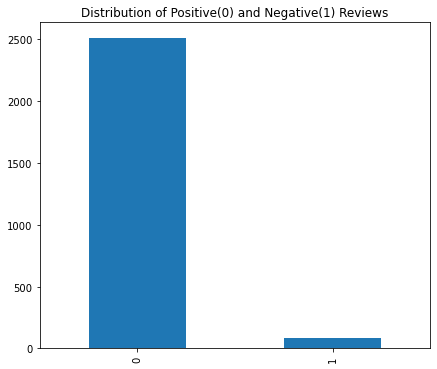

In [48]:
plt.figure(figsize=(7, 6))
train_df['category'].value_counts().plot(kind='bar')
plt.title("Distribution of Positive(0) and Negative(1) Reviews")
plt.show()

As we can notice from the above results, the products are getting 97% positive reviews and only 3% negative reviews.<br>
We can easily predict with our intuition, that a review would be positive but not accurate enough.

<h3>To predict if the review is negative or positive accurately, we need the data to be balanced enough to predict the correct category of the review.</h3>

To optimize this imbalanced data, we will perform over-sampling using **ADASYN(Adaptive Synthetic Sampling Approach)**

<h1>__________________________________________________________</h1>

## 4. Vectorizing the categorical variable

<p>As we know, all the ML models are good with numbers. So, we will convert the categorical column 'text' using CountVectorizer.<br>
It will convert the collection of text tokens in 'text' column, and return a matrix of the counts of occurences of each token in the Series.</p>

In [49]:
# import the CountVectorizer library
vectorizer = CountVectorizer(binary=True)

In [50]:
# learning vocabulary dictionary from the given tokens for reviews in 'text'

# Train Data
vectorizer.fit(list(new_train['text']))


CountVectorizer(binary=True)

In [51]:
# transform 'text' series to a matrix of the counts of each token.
train_vec = vectorizer.transform(new_train['text'])

test_vec = vectorizer.transform(new_train['text'])

In [52]:
train_vec.shape, test_vec.shape

((2598, 7354), (2598, 7354))

<h1>__________________________________________________________</h1>

## 5. Train Test Split

In [53]:
# extract the target label from the train data
y = new_train.category.values

# using 70% for the training and 30% for the test
x_train, x_test, y_train, y_test = train_test_split(train_vec, y, 
                                                    stratify=y, 
                                                    random_state=1, 
                                                    test_size=0.3)

In [54]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1818, 7354), (780, 7354), (1818,), (780,))

In [55]:
# Indexing the vectorized test data with the original index of Test Data
test_vec = test_vec[test_df.index]
test_vec

<866x7354 sparse matrix of type '<class 'numpy.int64'>'
	with 12922 stored elements in Compressed Sparse Row format>

<h1>__________________________________________________________</h1>

## 6. Over-Sampling
<p>We are using ADASYN as over-sampling techniques to balance our dataset</p>

In [56]:
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

In [57]:
x_train_ada.shape, y_train_ada.shape

((3510, 7354), (3510,))

<h1>__________________________________________________________</h1>

## 7. Model Building

### 7.1 Using Support Vector Classifier

In [58]:
from sklearn import svm
# classify using support vector classifier
sv = svm.SVC(probability=True)

# fit the SVC model based on the given training data
prob = sv.fit(x_train_ada, y_train_ada)

# perform classification and prediction on samples in x_test
y_pred_svm = sv.predict(x_test)

print("SVM Accuracy score : ", round(accuracy_score(y_test, y_pred_svm)* 100, 2), '%')
print("Recall_score(Macro) : ", round(recall_score(y_test, y_pred_svm, average='macro')*100, 2), '%')
print("Precision_Score(Macro) : ", round(precision_score(y_test, y_pred_svm, average='macro', zero_division=1)*100, 2), '%')

SVM Accuracy score :  94.87 %
Recall_score(Macro) :  49.07 %
Precision_Score(Macro) :  48.3 %


### 7.2 Using Cat Boost Classifier

In [59]:
# classify using CatBoost Classifier
cbr = CatBoostClassifier(eval_metric='Precision', iterations=20)

# fit the SVC model based on the given training data
prob1 = cbr.fit(x_train_ada, y_train_ada)

# perform classification and prediction on samples in x_test
y_pred_cat = cbr.predict(x_test)

print("CatBoost Accuracy score : ", round(accuracy_score(y_test, y_pred_cat)* 100, 2), '%')
print("Recall_score(Macro) : ", round(recall_score(y_test, y_pred_cat, average='macro')*100, 2), '%')
print("Precision_Score(Macro) : ", round(precision_score(y_test, y_pred_cat, average='macro', zero_division=1)*100, 2), '%')

Learning rate set to 0.5
0:	learn: 0.7357513	total: 109ms	remaining: 2.06s
1:	learn: 0.8168083	total: 213ms	remaining: 1.92s
2:	learn: 0.8523524	total: 311ms	remaining: 1.76s
3:	learn: 0.8852544	total: 409ms	remaining: 1.64s
4:	learn: 0.8795732	total: 502ms	remaining: 1.51s
5:	learn: 0.8876923	total: 597ms	remaining: 1.39s
6:	learn: 0.8974625	total: 708ms	remaining: 1.31s
7:	learn: 0.9030240	total: 809ms	remaining: 1.21s
8:	learn: 0.9063808	total: 908ms	remaining: 1.11s
9:	learn: 0.9092816	total: 1s	remaining: 1s
10:	learn: 0.9139108	total: 1.09s	remaining: 896ms
11:	learn: 0.9182920	total: 1.2s	remaining: 797ms
12:	learn: 0.9178515	total: 1.3s	remaining: 699ms
13:	learn: 0.9188192	total: 1.41s	remaining: 604ms
14:	learn: 0.9341189	total: 1.52s	remaining: 507ms
15:	learn: 0.9331193	total: 1.63s	remaining: 408ms
16:	learn: 0.9331193	total: 1.73s	remaining: 305ms
17:	learn: 0.9326203	total: 1.84s	remaining: 205ms
18:	learn: 0.9336188	total: 1.94s	remaining: 102ms
19:	learn: 0.9321219	tot

### 7.3 Using Extreme Gradient Boosting Classifier

In [60]:
# classify using support vector classifier
xg = xgb.XGBClassifier(max_depth=6,learning_rate=0.1)

# fit the SVC model based on the given training data
prob = xg.fit(x_train_ada, y_train_ada)

# perform classification and prediction on samples in x_test
y_pred_xgb = xg.predict(x_test)

print("XGBoost Accuracy score : ", round(accuracy_score(y_test, y_pred_xgb)* 100, 2), '%')
print("Recall_score(Macro) : ", round(recall_score(y_test, y_pred_xgb, average='macro')*100, 2), '%')
print("Precision_Score(Macro) : ", round(precision_score(y_test, y_pred_xgb, average='macro', zero_division=1)*100, 2), '%')

XGBoost Accuracy score :  98.97 %
Recall_score(Macro) :  84.62 %
Precision_Score(Macro) :  99.48 %


### 7.4 Using Decision Tree Classifier

In [61]:
dtc = DecisionTreeClassifier(max_depth=10, random_state=42)

# fit the DecisionTree model based on the given training data
prob = dtc.fit(x_train_ada, y_train_ada)

# perform classification and prediction on samples in x_test
y_pred_dtc = dtc.predict(x_test)

print("DecisionTree Accuracy score : ", round(accuracy_score(y_test, y_pred_dtc)* 100, 2), '%')
print("Recall_score(Macro) : ", round(recall_score(y_test, y_pred_dtc, average='macro')*100, 2), '%')
print("Precision_Score(Macro) : ", round(precision_score(y_test, y_pred_dtc, average='macro')*100, 2), '%')

DecisionTree Accuracy score :  76.03 %
Recall_score(Macro) :  76.46 %
Precision_Score(Macro) :  54.46 %


### 7.5 Using Random Forest Classifier

In [62]:
rfc = RandomForestClassifier(max_depth=10, random_state=42)

# fit the DecisionTree model based on the given training data
prob = rfc.fit(x_train_ada, y_train_ada)

# perform classification and prediction on samples in x_test
y_pred_rfc = rfc.predict(x_test)

print("DecisionTree Accuracy score : ", round(accuracy_score(y_test, y_pred_rfc)* 100, 2), '%')
print("Recall_score(Macro) : ", round(recall_score(y_test, y_pred_rfc, average='macro')*100, 2), '%')
print("Precision_Score(Macro) : ", round(precision_score(y_test, y_pred_rfc, average='macro')*100, 2), '%')

DecisionTree Accuracy score :  81.28 %
Recall_score(Macro) :  73.61 %
Precision_Score(Macro) :  54.8 %


<h1>__________________________________________________________</h1>

## 8. Metrics Comparison & Generating Predictions

As we can observe that, **XGBClassifier gives better Accuracy Score of `98.97%`, Recall Score(Macro) of `84.62` and Precison Score(Macro) of `99.48%`**.
<br>
Let's continue with generating our final predictions on the Test data using **XGBClassifier** itself.

In [63]:
# Make prediction on the test data using XGBClassifier
final_pred = xg.predict(test_vec)

In [64]:
# Saving the predictions as per the Id column in a new dataframe
new_frame = pd.DataFrame()
new_frame['category'] = final_pred

In [65]:
# Exporting the predictions to a csv file
new_frame.to_csv('output/submission_xgb.csv', header=True, index = False)